# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [50]:
import numpy as np
import os
import imageio
from skimage.transform import resize
import matplotlib.pyplot as plt
from imageio import imread
import datetime
import cv2

We set the random seed so that the results don't vary drastically.

In [51]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [52]:
train_doc = np.random.permutation(open('../datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('../datasets/Project_data/val.csv').readlines())
batch_size = 50 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [53]:
def getImgTensor(n_frames, size):#method to enable experimenting with img_idx and image size
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    y= size
    z= size
    channels = 3
    return [img_idx, y, z, channels]

In [54]:
def getBatchData(source_path, t, batch, batch_size, img_tensor):
    
    [x,y,z,num_channels] = [len(img_tensor[0]),img_tensor[1], img_tensor[2], img_tensor[3] ]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,num_channels)) 
    # x is the number of images you use for each video, 
    #(y,z) is the final size of the input images and 
    #num_challens  = 3 is the number of channels RGB
    
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            image_resized= resize(image, (y,z)) #imresize(image,(y,z, num_channels))

            # normalizing images
            batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
            batch_data[folder,idx,:,:,1] = (image_resized[:,:,0])/255
            batch_data[folder,idx,:,:,2] = (image_resized[:,:,0])/255

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels

In [55]:
def get_batch(source_path, folder_list, batch_size,batch,t,img_idx):
  batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
  batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
  for folder in range(batch_size): # iterate over the batch_size
      imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
      for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
          image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
          h,w = image.shape[0:2]
          #crop the images and resize them. Note that the images are of 2 different shape 
          #and the conv3D will throw error if the inputs in a batch have different shapes
          if (h>120) and (w>160):
            image = cv2.resize(image,(160,120),interpolation = cv2.INTER_NEAREST)
          
          #Crop the Image
          image = image[:,20:140,:]

          batch_data[folder,idx,:,:,0] = cv2.normalize(image[:,:,0],None,0.00,1.00,cv2.NORM_MINMAX)#normalise and feed in the image
          batch_data[folder,idx,:,:,1] = cv2.normalize(image[:,:,1],None,0.00,1.00,cv2.NORM_MINMAX)#normalise and feed in the image
          batch_data[folder,idx,:,:,2] = cv2.normalize(image[:,:,2],None,0.00,1.00,cv2.NORM_MINMAX)#normalise and feed in the image
          
      batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
  return batch_data, batch_labels 

In [56]:
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)
        
        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)

In [57]:
def generator_new(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = range(0,30)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size # calculate the number of batches
        for batch in range(num_batches):  # we iterate over the number of batches
          yield get_batch(source_path, folder_list, batch_size,batch,t,img_idx)
        
        # write the code for the remaining data points which are left after full batches
        remaining = len(folder_list) % batch_size
        if remaining != 0:
          batch_size = remaining
          yield get_batch(source_path, folder_list, batch_size,batch,t,img_idx)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [58]:
curr_dt_time = datetime.datetime.now()
train_path = '../datasets/Project_data/train'
val_path = '../datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


#### Function for the Batch Size

In [59]:
def gen_train_val (batch_size):
  train_generator = generator_new(train_path, train_doc, batch_size)
  val_generator = generator_new(val_path, val_doc, batch_size)

  if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
  else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
  else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
  return train_generator,val_generator,steps_per_epoch,validation_steps

#### Function for Checkpoint

In [60]:
def set_checkpoint(model_name,fact=0.1,pati=8):
  
  logdir = os.path.join("logs",model_name)
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1,write_images=True)

  filepath = os.path.join("model",model_name+'.h5',)
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

  LR = ReduceLROnPlateau(monitor='val_loss', factor=fact,patience=pati,mode='min')

  return [tensorboard_callback, checkpoint, LR]

In [61]:
# define image tensor size
img_tensor = getImgTensor(20, 120)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 120, 120, 3]


In [62]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  ../datasets/Project_data/train ; batch size = 50
(50, 20, 120, 120, 3)
Source path =  ../datasets/Project_data/val ; batch size = 50
(50, 20, 120, 120, 3)


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [63]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling3D, MaxPooling2D 
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.regularizers import l2

#write your model here

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

## Convolution 3D : Initial Model

- Creating a base model where we just want to check if data fits the model.
- According to our expectation the model should overfit.

In [64]:
#write your model here
model = Sequential([
                    Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(30,120,120,3)),
                    MaxPooling3D(pool_size=(2, 2, 2)),
                    Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'),
                    MaxPooling3D(pool_size=(2, 2, 2)),
                    Flatten(),
                    Dense(5, activation='softmax')
])

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [65]:
#optimiser =  tf.keras.optimizers.Adam(learning_rate=0.001) #write your optimizer
optimiser =  tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 28, 118, 118, 64)  5248      
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 14, 59, 59, 64)   0         
 3D)                                                             
                                                                 
 conv3d_13 (Conv3D)          (None, 12, 57, 57, 128)   221312    
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 6, 28, 28, 128)   0         
 3D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 602112)            0         
                                                                 
 dense_6 (Dense)             (None, 5)                

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [66]:
train_generator,val_generator,steps_per_epoch,validation_steps = gen_train_val(batch_size=15)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [67]:
# Check Point for the base
callbacks_list = set_checkpoint('model')

In [68]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps)

Source path =  ../datasets/Project_data/train ; batch size = 15
Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 3.4592 - categorical_accuracy: 0.2971Source path =  ../datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 1.62332, saving model to model/model.h5
45/45 [==============================] - 53s 1s/step - loss: 3.4592 - categorical_accuracy: 0.2971 - val_loss: 1.6233 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 1.3436 - categorical_accuracy: 0.4741
Epoch 00002: val_loss improved from 1.62332 to 1.27795, saving model to model/model.h5
45/45 [==============================] - 13s 298ms/step - loss: 1.3436 - categorical_accuracy: 0.4741 - val_loss: 1.2779 - val_categorical_accuracy: 0.5429 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 1.2290 - categorical_accuracy: 0.4963
Epoch 00003: val_loss did not improve from 1.27795


Best Epoch (Epoch 17) Result from the above odel
**Train Accuracy : 99.26**   **Validation Accuracy : 72.86**

- We can clearly see that the above Model is overfitting, it was the purpose of the initial model to verify the fit

## Convolution 3D Models

- Starting with the CONV 3D models
- We we see the accuracy by playing around with the Batch size, Optimizer, model architecture
- We will also expirment with the no. of layers and Drop outs in the Model Architecture

### Conv 3D Model1 : (Batch Size: 15 , No. of Frames = 30 , Optimizer=SGD)

In [69]:
#Changing the batch Size
train_generator,val_generator,steps_per_epoch,validation_steps = gen_train_val(batch_size=15)

#Setting the Callback Parameters
callbacks_list1 = set_checkpoint('model1',pati=6)

In [70]:
model1 = Sequential([
                    Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(30,120,120,3)),
                    BatchNormalization(),
                    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'),
                    BatchNormalization(),
                    Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
                    Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
                    Flatten(),
                    Dense(64, activation='relu', kernel_initializer='he_uniform'),
                    BatchNormalization(),
                    Dense(5, activation='softmax')
])

In [71]:
optimiser = tf.keras.optimizers.SGD(learning_rate=0.001) # write your optimizer
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_14 (Conv3D)          (None, 28, 118, 118, 16)  1312      
                                                                 
 batch_normalization_10 (Bat  (None, 28, 118, 118, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_15 (Conv3D)          (None, 26, 116, 116, 32)  13856     
                                                                 
 batch_normalization_11 (Bat  (None, 26, 116, 116, 32)  128      
 chNormalization)                                                
                                                                 
 conv3d_16 (Conv3D)          (None, 24, 114, 114, 64)  55360     
                                                                 
 batch_normalization_12 (Bat  (None, 24, 114, 114, 64)

In [72]:
model1.fit(train_generator, 
          steps_per_epoch=steps_per_epoch, 
          epochs=50, 
          verbose=1,
          validation_data=val_generator,
          validation_steps=validation_steps,
          callbacks=callbacks_list1)

Source path =  ../datasets/Project_data/train ; batch size = 15
Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 1.1703 - categorical_accuracy: 0.5686Source path =  ../datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 1.70288, saving model to model/model1.h5
45/45 [==============================] - 55s 1s/step - loss: 1.1703 - categorical_accuracy: 0.5686 - val_loss: 1.7029 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 0.9839 - categorical_accuracy: 0.6296
Epoch 00002: val_loss did not improve from 1.70288
45/45 [==============================] - 18s 396ms/step - loss: 0.9839 - categorical_accuracy: 0.6296 - val_loss: 1.9555 - val_categorical_accuracy: 0.2429 - lr: 0.0010
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 1.1275 - categorical_accuracy: 0.5037
Epoch 00003: val_loss did not improve from 1.70288
45/45 [============================

Best Epoch(Epoch 50) Result from the above Model1 
 **Train Accuracy : 91.85**
 **Validation Accuracy : 72.86**

- We can clearly see that  Model1 is performing better in terms of generalizing the model.
- But clearly the Accuracy is less on both the Train and Validation data.

### CONV3D : Model 2

#### Conv 3D Model1 : (Batch Size: 10 , No. of Frames = 30 , Optimizer=Adam , Dense Layer= 64)

In [73]:
#Changing the batch Size
train_generator,val_generator,steps_per_epoch,validation_steps = gen_train_val(batch_size=20)

#Setting the Callback Parameters
callbacks_list2 = set_checkpoint('model2',pati=6)

In [74]:
# Model Architecture
model2 = Sequential([
                    Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(30,120,120,3)),
                    BatchNormalization(),
                    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'),
                    BatchNormalization(),
                    Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
                    Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
                    Flatten(),
                    Dense(64, activation='relu', kernel_initializer='he_uniform'),
                    BatchNormalization(),
                    Dense(5, activation='softmax')
])

In [75]:
#Compiling the Model
optimiser =  tf.keras.optimizers.Adam(learning_rate=0.001) #write your optimizer
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 28, 118, 118, 16)  1312      
                                                                 
 batch_normalization_15 (Bat  (None, 28, 118, 118, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_19 (Conv3D)          (None, 26, 116, 116, 32)  13856     
                                                                 
 batch_normalization_16 (Bat  (None, 26, 116, 116, 32)  128      
 chNormalization)                                                
                                                                 
 conv3d_20 (Conv3D)          (None, 24, 114, 114, 64)  55360     
                                                                 
 batch_normalization_17 (Bat  (None, 24, 114, 114, 64)

In [76]:
# Model Fit
model2.fit(train_generator, 
          steps_per_epoch=steps_per_epoch, 
          epochs=50, 
          verbose=1,
          validation_data=val_generator,
          validation_steps=validation_steps,
          callbacks=callbacks_list2)

Source path =  ../datasets/Project_data/train ; batch size = 20
Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 1.4144 - categorical_accuracy: 0.4811Source path =  ../datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 4.10415, saving model to model/model2.h5
34/34 [==============================] - 63s 2s/step - loss: 1.4144 - categorical_accuracy: 0.4811 - val_loss: 4.1041 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 1.4850 - categorical_accuracy: 0.4608
Epoch 00002: val_loss improved from 4.10415 to 2.55220, saving model to model/model2.h5
34/34 [==============================] - 26s 794ms/step - loss: 1.4850 - categorical_accuracy: 0.4608 - val_loss: 2.5522 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/50
34/34 [==============================] - ETA: 0s - loss: 1.6098 - categorical_accuracy: 0.3725
Epoch 00003: val_loss did not improve from 2.5522

Best Epoch (Epoch 44) Result from the above Model2:
 **Train Accuracy : 62.75**
 **Validation Accuracy : 62**

- We can clearly see that  Model1 is performing better in terms of generalizing the model.
- Accuracy is also less than Model 1

### CONV3D : Model 3
(Batch Size: 15 , No. of Frames = 30 , Optimizer=Adam , LR =0.01,Dense_Layer=32)

In [77]:
#Changing the batch Size
train_generator,val_generator,steps_per_epoch,validation_steps = gen_train_val(batch_size=15)

#Setting the Callback Parameters
callbacks_list3 = set_checkpoint('model3',pati=6)

In [78]:
# Model Architecture
model3 = Sequential([
                    Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(30,120,120,3)),
                    BatchNormalization(),
                    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'),
                    BatchNormalization(),
                    Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
                    Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
                    Flatten(),
                    Dense(32, activation='relu', kernel_initializer='he_uniform'),
                    #Dropout(0.1),
                    BatchNormalization(),
                    Dense(5, activation='softmax')
])

In [ ]:
## Model Fit
model3.fit(train_generator, 
          steps_per_epoch=steps_per_epoch, 
          epochs=50, 
          verbose=1,
          validation_data=val_generator,
          validation_steps=validation_steps,
           callbacks=callbacks_list3)

Source path =  ../datasets/Project_data/train ; batch size = 15
Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 1.4440 - categorical_accuracy: 0.3967Source path =  ../datasets/Project_data/val ; batch size = 15

Epoch 00001: val_loss improved from inf to 54.05769, saving model to model/model3.h5
45/45 [==============================] - 57s 1s/step - loss: 1.4440 - categorical_accuracy: 0.3967 - val_loss: 54.0577 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 1.5371 - categorical_accuracy: 0.3778
Epoch 00002: val_loss improved from 54.05769 to 8.66809, saving model to model/model3.h5
45/45 [==============================] - 20s 460ms/step - loss: 1.5371 - categorical_accuracy: 0.3778 - val_loss: 8.6681 - val_categorical_accuracy: 0.3000 - lr: 0.0100
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 1.5880 - categorical_accuracy: 0.2889
Epoch 00003: val_loss did not improve from 8.6

Best Epoch (Epoch 35) Result from the above Model3:
 **Train Accuracy : 54**
 **Validation Accuracy : 67**

### Conv3D: Model 4

- (Batch Size: 7 , No. of Frames = 30 , Optimizer=Adam , LR =0.0001,Dense_Layer=32)

In [ ]:
#Changing the batch Size
train_generator,val_generator,steps_per_epoch,validation_steps = gen_train_val(batch_size=7)

#Setting the Callback Parameters
callbacks_list3 = set_checkpoint('model4',pati=6)

In [ ]:
model4 = Sequential([
                    Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same', input_shape=(30,120,120,3)),
                    BatchNormalization(),
                    #MaxPooling3D(pool_size=(2, 2, 2)),
                    Conv3D(32, kernel_size=(3, 3, 3), activation='relu',padding='same', kernel_initializer='he_uniform'),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
                    Conv3D(64, kernel_size=(3, 3, 3), activation='relu',padding='same', kernel_initializer='he_uniform'),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
                    Conv3D(128, kernel_size=(3, 3, 3), activation='relu',padding='same', kernel_initializer='he_uniform'),
                    BatchNormalization(),
                    MaxPooling3D(pool_size=(2, 2, 2)),
                    Flatten(),
                    Dense(32, activation='relu', kernel_initializer='he_uniform'),
                    #Dropout(0.25),
                    BatchNormalization(),
                    Dense(5, activation='softmax')
])

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001) # write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_14 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 batch_normalization_15 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_15 (Conv3D)          (None, 30, 120, 120, 32)  13856     
                                                                 
 batch_normalization_16 (Bat  (None, 30, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 60, 60, 32)   0         
 3D)                                                             
                                                      

In [ ]:
model4.fit(train_generator, 
          steps_per_epoch=steps_per_epoch, 
          epochs=50, 
          verbose=1,
          validation_data=val_generator,
          validation_steps=validation_steps,
          callbacks=callbacks_list)

Source path =  ../datasets/Project_data/train ; batch size = 7
Epoch 1/50
95/95 [==============================] - ETA: 0s - loss: 1.2372 - categorical_accuracy: 0.5083Source path =  ../datasets/Project_data/val ; batch size = 7

Epoch 00001: val_loss did not improve from 0.83583
95/95 [==============================] - 55s 555ms/step - loss: 1.2372 - categorical_accuracy: 0.5083 - val_loss: 4.3231 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04
Epoch 2/50
95/95 [==============================] - ETA: 0s - loss: 0.8221 - categorical_accuracy: 0.7032
Epoch 00002: val_loss did not improve from 0.83583
95/95 [==============================] - 30s 315ms/step - loss: 0.8221 - categorical_accuracy: 0.7032 - val_loss: 2.4224 - val_categorical_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 3/50
95/95 [==============================] - ETA: 0s - loss: 0.8638 - categorical_accuracy: 0.6880
Epoch 00003: val_loss did not improve from 0.83583
95/95 [==============================] - 25s 266ms/step - l

Best Epoch (Epoch 46) Result from the above Model3:
 **Train Accuracy : 89**
 **Validation Accuracy : 80**

- We can clearly see that  Model4 is performing better in terms of generalizing the model.
- Validation Accuracy is also also better than Model 1, Model 2 and Model 3

In [69]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Validation", max(h.history['categorical_accuracy']))
    print("Max. Validation Accuracy", max(h.history['val_categorical_accuracy']))

# LSTM Model Iterations

In [38]:
mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

# LSTM with Transfer learning [mobile net]

n_frames = 20
num_epochs = 20
batch_size = 50
size = 120

img_tensor = getImgTensor(n_frames, size)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model_lstm = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
], name="mobilenet_lstm")

for layer in model_lstm.layers:
    layer.trainable = False

model_lstm.add(TimeDistributed(BatchNormalization()))
model_lstm.add(TimeDistributed(MaxPooling2D(tuple([2]*2))))
model_lstm.add(TimeDistributed(Flatten()))

model_lstm.add(LSTM(256))
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(256,activation='relu'))
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(5, activation='softmax'))

#model_lstm.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_lstm.summary())

model_lstm_history = model_lstm.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_4 (LSTM)               (None, 256)            

/tmp/ipykernel_206/23933416.py:60: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_lstm_history = model_lstm.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20


2024-06-30 17:17:28.042396: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.92GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 1/14 [=>............................] - ETA: 1:24 - loss: 1.7691 - categorical_accuracy: 0.1800

2024-06-30 17:17:34.723187: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.92GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 2/14 [===>..........................] - ETA: 1:17 - loss: 1.6204 - categorical_accuracy: 0.3000

2024-06-30 17:17:42.059780: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.92GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 3/14 [=====>........................] - ETA: 1:13 - loss: 1.5945 - categorical_accuracy: 0.3000

2024-06-30 17:17:49.259931: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.92GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 4/14 [=======>......................] - ETA: 1:08 - loss: 1.5547 - categorical_accuracy: 0.3400

2024-06-30 17:17:55.352213: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.92GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 5/14 [=========>....................] - ETA: 1:00 - loss: 1.5202 - categorical_accuracy: 0.3600

2024-06-30 17:18:02.837455: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.92GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


14/14 [==============================] - ETA: 0s - loss: 1.2892 - categorical_accuracy: 0.4600Source path =  ../datasets/Project_data/val ; batch size = 50

Epoch 00001: saving model to model_init_2024-06-3016_20_20.332351/model-00001-1.28916-0.46003-1.35785-0.45000.h5
14/14 [==============================] - 117s 9s/step - loss: 1.2892 - categorical_accuracy: 0.4600 - val_loss: 1.3579 - val_categorical_accuracy: 0.4500 - lr: 0.0010
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 0.5963 - categorical_accuracy: 0.7967
Epoch 00002: saving model to model_init_2024-06-3016_20_20.332351/model-00002-0.59627-0.79670-1.28022-0.57000.h5
14/14 [==============================] - 45s 3s/step - loss: 0.5963 - categorical_accuracy: 0.7967 - val_loss: 1.2802 - val_categorical_accuracy: 0.5700 - lr: 0.0010
Epoch 3/20
14/14 [==============================] - ETA: 0s - loss: 0.6283 - categorical_accuracy: 0.7747
Epoch 00003: saving model to model_init_2024-06-3016_20_20.332351/model-

LSTM: Model 5

Base model with 20 frames, 30 epochs, 64 batch size and 120x120 image size

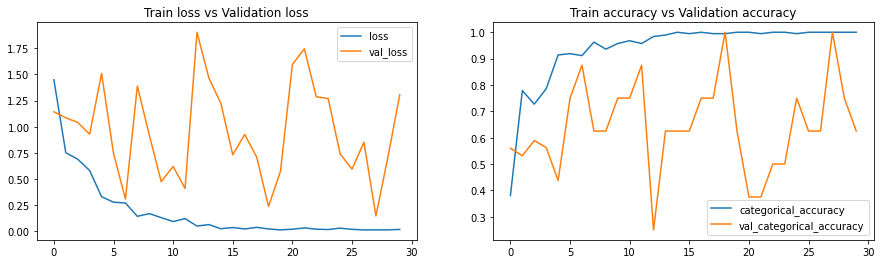

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 1.0


In [30]:
# plotModelHistory(model_lstm_history) # batch size 64, epochs 30
# we notice wide fluctuations in valaccuracy while train accuracy reaches almost 1.0 very early
# this is a sign of overfitting. let us try smaller batch size[50] and epochs [20]

LSTM : Model 6

LSTM 2nd model with 20 frames, reduced epochs to 20 from 30 and reduced batch size to 50 from 64. Model with highest Validation Accuracy of .88

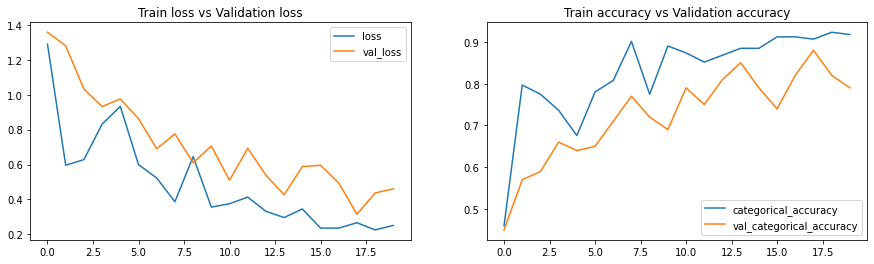

Max. Training Accuracy 0.9230769276618958
Max. Validaiton Accuracy 0.8799999952316284


In [39]:
#plotModelHistory(model_lstm_history) # batch size 50, epochs 20
# here we see a consistent pattern in accuracy improvement in both train and val set
# this is a more reliable model

#Epoch 00018: saving model to model_init_2024-06-3016_20_20.332351/model-00018-0.26692-0.90659-0.31584-0.88000.h5


# GRU Model Iterations

In [70]:
# GRU model
mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

n_frames = 20
num_epochs = 30
batch_size = 50
size = 120
#gru units changed to 128 from 256
# gru units further reduced to 64
#increase epochs to 30

img_tensor = getImgTensor(n_frames, size)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model_gru = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
], name="mobilenet_gru")

for layer in model_gru.layers:
    layer.trainable = False

model_gru.add(TimeDistributed(BatchNormalization()))
model_gru.add(TimeDistributed(MaxPooling2D(tuple([2]*2))))
model_gru.add(TimeDistributed(Flatten()))

model_gru.add(GRU(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))# units=256 in base model. added kernel_regularizer=l2(0.001)
model_gru.add(Dropout(0.5))# 0.2 in base layer

model_gru.add(Dense(64,activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))# units=256 in base model. added kernel_regularizer=l2(0.001)
model_gru.add(Dropout(0.5))# 0.2 in base layer

model_gru.add(Dense(5, activation='softmax'))

model_gru.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_gru.summary())

model_gru_history = model_gru.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



Model: "mobilenet_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                                 
 gru_5 (GRU)                 (None, 64)              

/tmp/ipykernel_204/840909917.py:62: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_gru_history = model_gru.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 2.3482 - categorical_accuracy: 0.1885Source path =  ../datasets/Project_data/val ; batch size = 50

Epoch 00001: saving model to model_init_2024-07-0214_31_03.174998/model-00001-2.34818-0.18854-1.87677-0.34000.h5
14/14 [==============================] - 109s 8s/step - loss: 2.3482 - categorical_accuracy: 0.1885 - val_loss: 1.8768 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 1.9893 - categorical_accuracy: 0.3187
Epoch 00002: saving model to model_init_2024-07-0214_31_03.174998/model-00002-1.98935-0.31868-1.83232-0.44000.h5
14/14 [==============================] - 44s 3s/step - loss: 1.9893 - categorical_accuracy: 0.3187 - val_loss: 1.8323 - val_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 1.9661 - categorical_accuracy: 0.3681
Epoch 00003: saving model to model_init_2024-07-0214_31_03.17

GRU : Model 7

Start with a base GRU model with same hyper parameters as LSTM 

frames = 20
epochs = 20
batch_size = 50
Image size = 120x120
GRU units = 256
Dropout Rate = 0.2

trainable param get reduced to 1 million from 4 million params in LSTM

In [ ]:
#plotModelHistory(model_gru_history) 
#n_frames = 20
#num_epochs = 20
#batch_size = 50
#size = 120

GRU: Model 8

Increase the number of frames to see if more data adds to model improvement

Increasing number of frames did not result in a better validation accuracy instead we got an overfitted model. Change frame size back to 20

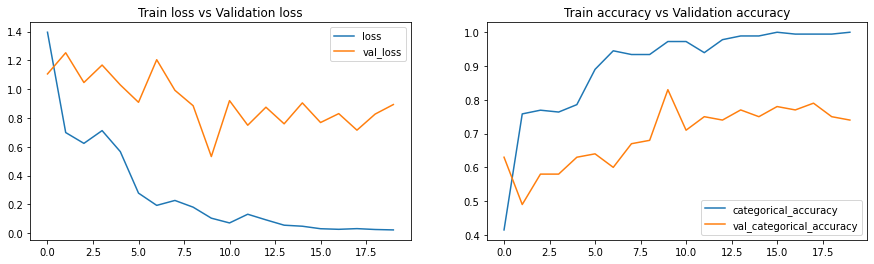

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.8299999833106995


In [14]:
#plotModelHistory(model_gru_history)
#n_frames = 25 increased number of frames to 25 from 20
#num_epochs = 20
#batch_size = 50
#size = 120
#only a minor inprovement in accuracy

GRU: Model 9

Let us try reducing the image size to 100x100

Reducing image size is resulting is critical data loss for the model. Change image size back to 120x120

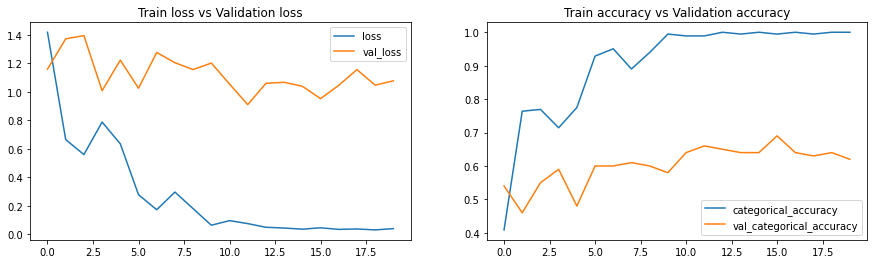

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.6899999976158142


In [18]:
#plotModelHistory(model_gru_history)
#n_frames = 20 reduced number of frames back to 20 
#num_epochs = 20
#batch_size = 50
#size = 100 reduced image size to 100X100 - significantly reduced accuracy

GRU: Model 10

Try with reduced batch size of 30

This seems reasonable trade-off between training and validation accuracies. Let us focus on reducing trainable parameters.

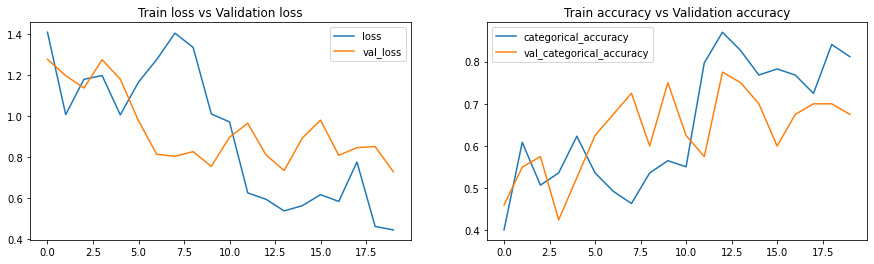

Max. Training Accuracy 0.8695651888847351
Max. Validaiton Accuracy 0.7749999761581421


In [21]:
#plotModelHistory(model_gru_history)
#n_frames = 20
#num_epochs = 20
#batch_size = 30 -  reduced batch size to 30
#size = 120

GRU : Model 11

Let us try to reduce the trainable params by reducing GRU and Dense layer units to 128

We see that the trainable params reduced to 400k from 1 million but the model is again overfitting with Training accuracy of 100%


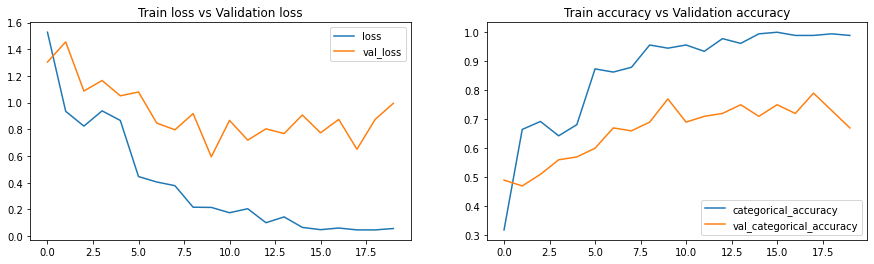

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.7900000214576721


In [13]:
#plotModelHistory(model_gru_history)
#n_frames = 20
#num_epochs = 20
#batch_size = 50
#size = 120
#gru units changed to 128 from 256 - significantly reduced trainable params from 1m to 400k but the model is overfitting now

GRU : Model 12

Let us use regularization in GRU and dense layers and increase dropout rate to 0.5 to reduce overfitting.

This is a best GRU model we have and with only 400k trainable parameters. However, it lags behind LSMT (model6) which had 88% validation accuracy. We will pick this model up due to it being light weight. 

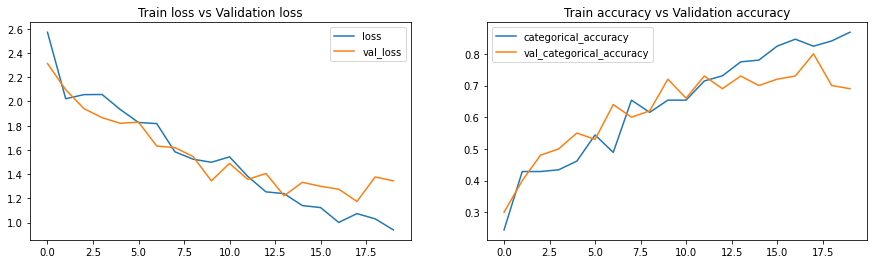

Max. Training Accuracy 0.8681318759918213
Max. Validation Accuracy 0.800000011920929


In [45]:
#plotModelHistory(model_gru_history)
# we need to reduce overfitting by :
# regularization for GRU and dense layers with kernel_regularizer=l2(0.001)
# increased dropout rate to 0.5

GRU : Modlel 13

Reduce GRU and Dense Units to 64

We see that trainable params got reduced to 200k from 400k but both training and validation accuracies have gone down to 70s

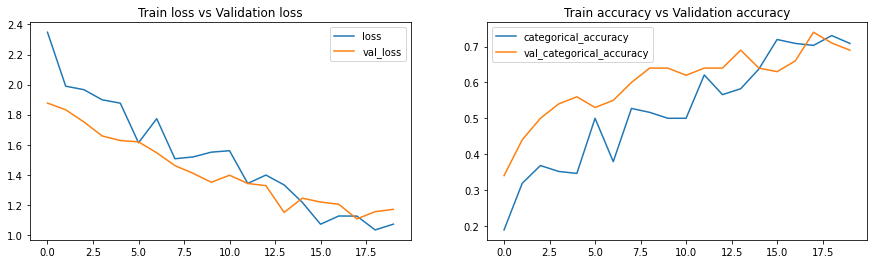

Max. Training Accuracy 0.7307692170143127
Max. Validation Accuracy 0.7400000095367432


In [58]:
#plotModelHistory(model_gru_history)
#reduce units in GRU and dense layers to 64 - trainable params reduced to 200k from 400k

GRU: Model 14

Let's increase epochs to 30 to see if we get a better accuracy score at higher epochs.

On increasing epochs to 30 we do not see any significant improvement in validation accuracy. In fact Validation accuracy seems to be plateauing

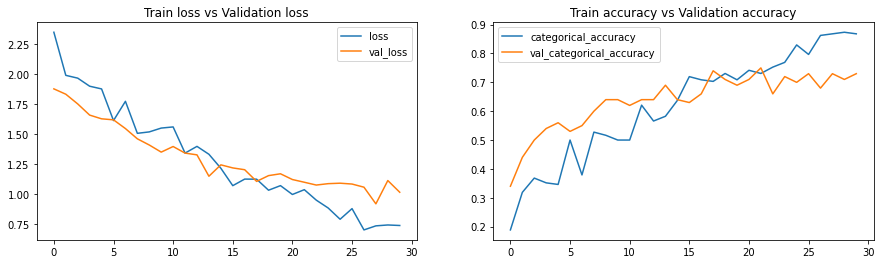

Max. Training Accuracy 0.8736263513565063
Max. Validation Accuracy 0.75


In [71]:
plotModelHistory(model_gru_history)
# increase epochs to 30

We conclude that LSTM model6 is the most accurate model with 88% Validation accuracy. However, It uses 4m trainable parameters.

While GRU model12 gets 80% accuracy with only 400k parameters.

We select GRU model12 as our final model. 
